# 1 Dogs breeds

https://youtu.be/JNxcznsrRb8?t=1h31m8s

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.set_device(0)

In [4]:
PATH = "data/dogbreed/"
sz = 224
arch = resnext101_64
bs = 58

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [6]:
n

10222

In [7]:
len(val_idxs)

2044

In [8]:
# If you haven't downloaded weights.tgz yet, download the file.
#     http://forums.fast.ai/t/error-when-trying-to-use-resnext50/7555
#     http://forums.fast.ai/t/lesson-2-in-class-discussion/7452/222
!wget -O fastai/weights.tgz http://files.fast.ai/models/weights.tgz

--2018-01-24 12:55:10--  http://files.fast.ai/models/weights.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1195411318 (1.1G) [text/plain]
Saving to: ‘fastai/weights.tgz’

fastai/weights.tgz  100%[===================>]   1.11G  34.4MB/s    in 38s     

2018-01-24 12:55:52 (30.3 MB/s) - ‘fastai/weights.tgz’ saved [1195411318/1195411318]



In [16]:
!tar xvfz fastai/weights.tgz -C fastai

weights/
weights/wrn_50_2f.pth
weights/resnext_101_32x4d.pth
weights/resnext_101_64x4d.pth
weights/inceptionresnetv2-d579a627.pth
weights/inceptionv4-97ef9c30.pth
weights/resnext_50_32x4d.pth


## 2 Initial exploration

In [8]:
!ls {PATH}

labels.csv  sample_submission.csv  subm  test  tmp  train


In [9]:
label_df = pd.read_csv(label_csv)

In [10]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [12]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [13]:
fn = PATH + data.trn_ds.fnames[0]; fn

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

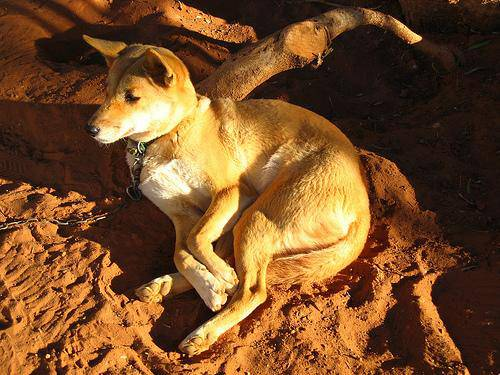

In [14]:
img = PIL.Image.open(fn); img

In [15]:
img.size

(500, 375)

In [16]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [17]:
row_sz, col_sz = list(zip(*size_d.values()))

In [18]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [19]:
row_sz[:5]

array([500, 500, 500, 500, 500])

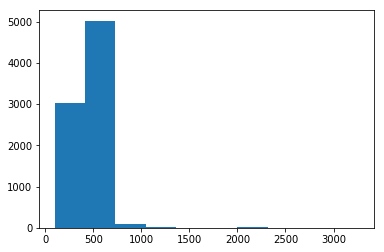

In [20]:
plt.hist(row_sz);

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

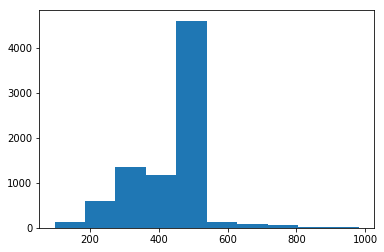

In [21]:
plt.hist(row_sz[row_sz < 1000])

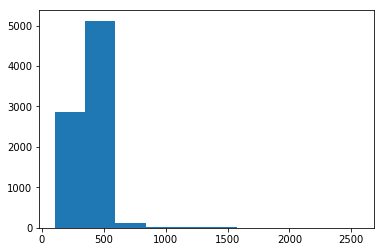

In [22]:
plt.hist(col_sz);

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

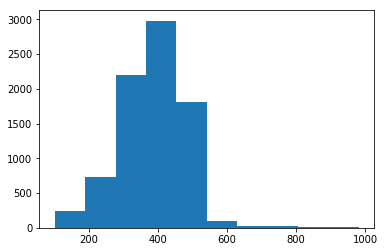

In [23]:
plt.hist(col_sz[col_sz < 1000])

In [24]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [25]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## 3 Initial model

In [26]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tmfs = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

### 3.1 Precompute

In [27]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [29]:
learn.fit(1e-2, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.953369   0.417489   0.905651  
    1      0.452394   0.314993   0.920977                    
    2      0.310134   0.294751   0.922893                    
    3      0.249502   0.305566   0.921935                    
    4      0.199666   0.300465   0.920977                    



[0.300465, 0.9209770146343443]

### 3.2 Augment

In [30]:
from sklearn import metrics

In [31]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [33]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.148577   0.47553    0.904215  
    1      0.539843   0.345226   0.916667                    



[0.34522644, 0.9166666716337204]

In [34]:
learn.precompute = False

In [35]:
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.461428   0.269782   0.926245  
    1      0.409727   0.257414   0.929598                    
    2      0.375959   0.248469   0.930077                    
    3      0.349082   0.235947   0.930556                    
    4      0.330319   0.237483   0.92433                     



[0.23748296, 0.924329506026374]

In [36]:
learn.save('224_pre')

In [ ]:
learn.load('224_pre')

## 4 Increase size

In [37]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs)) 
learn.freeze()

#Source:   
#    def set_data(self, data, precompute=False):
#        super().set_data(data)
#        if precompute:
#            self.unfreeze()
#            self.save_fc1()
#            self.freeze()
#            self.precompute = True
#        else:
#            self.freeze()
#File:      ~/fastai/courses/dl1/fastai/conv_learner.py

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [38]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [39]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.306527   0.234837   0.927203  
    1      0.296566   0.232511   0.925766                    
    2      0.273987   0.228817   0.930556                    



[0.22881675, 0.9305555621782938]

Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.

In [40]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.261201   0.229759   0.926724  
    1      0.258334   0.220122   0.926245                    
    2      0.245712   0.217593   0.931034                    
    3      0.247839   0.220838   0.933908                    
    4      0.215104   0.21559    0.931513                    
    5      0.20874    0.210346   0.936782                    
    6      0.198487   0.210754   0.933908                    



[0.21075392, 0.9339080469475852]

Training loss and validation loss are getting closer and smaller. We are on right track.

In [41]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
# http://forums.fast.ai/t/wiki-lesson-2/9399/41
#probs = np.exp(log_preds) # This does not work. This causes AttributeError: 'bool' object has no attribute 'mean' on accuracy()
probs = np.mean(np.exp(log_preds),0)
#accuracy(probs, y), metrics.log_loss(y, probs) # This does not work since accuracy() has changed.
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9315068493150684, 0.22091166726867872)

In [42]:
len(data.val_ds.y), data.val_ds.y[:5]

(2044, array([19, 15,  7, 99, 73]))

In [43]:
learn.save('299_pre')

In [ ]:
learn.load('299_pre')

In [44]:
learn.fit(1e-2, 1, cycle_len=2) # 1+1 = 2 epochs

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.201131   0.211465   0.933908  
    1      0.196877   0.212951   0.931513                    



[0.21295144, 0.9315134088198344]

In [45]:
learn.save('299_pre')

In [46]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
# accuracy(probs, y), metrics.log_loss(y, probs)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9324853228962818, 0.2263276811552095)

This dataset is so similar to ImageNet dataset. Training convolution layers doesn't help much. We are not going to unfreeze.

## 5 Create submission

https://youtu.be/9C06ZPF8Uuc?t=1905

In [47]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [48]:
data.test_ds.fnames

['test/57df9fc7793c4c40e806167ea94773a5.jpg',
 'test/56883df95a5356a29297c6dccfab0b47.jpg',
 'test/f12b509213db8bb0a721fcd228b31f0e.jpg',
 'test/a59fa6f74528014c4ffe94e117868abe.jpg',
 'test/d6da712fa79d6631324452fa74d648a3.jpg',
 'test/6a2cfab843ba8a78ab3f179a56b9d8e2.jpg',
 'test/a057d4b2a4343cb814937b517fb3be9a.jpg',
 'test/957379d51e207de4885b41d0b1758d8c.jpg',
 'test/56769dd3037ce85d52c2ef9b951137de.jpg',
 'test/f90f630e3728dfe9428e291af0cc4af5.jpg',
 'test/86c2d71776b76d0c7acdf34a87b7f9c7.jpg',
 'test/0cf7c74a10aa9c602d194717ab781794.jpg',
 'test/cf64016d08aacd4e9b6af996aa2deda9.jpg',
 'test/b3c8be64d0c83b0350bc79e61276fcb0.jpg',
 'test/cf9045c5f367cc2d012bf545f0a56b52.jpg',
 'test/a9a33f0585e5af26dffd6dc0a00ba88f.jpg',
 'test/67ed04767d1db6ecee253f8bd49fafd9.jpg',
 'test/60dc0b634487ca5c243799a9673f368e.jpg',
 'test/ab9befc0cdafaf3784775f5e833368b0.jpg',
 'test/62cb6f10735860b02cfbe6d6ba8a2d55.jpg',
 'test/76ac0074b7bec31ef8376a24b671a4e3.jpg',
 'test/1381912fe152f7873af101cf0d5

In [49]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
# probs = np.exp(log_preds)
# accuracy(log_preds, y), metrcs.log_loss(y, probs)
probs = np.mean(np.exp(log_preds),0)
#accuracy_np(probs, y), metrcs.log_loss(y, probs) # This does not make sense since test dataset has no labels

In [50]:
probs.shape # (n_images, n_classes)

(10357, 120)

In [51]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [52]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [53]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,57df9fc7793c4c40e806167ea94773a5,2.514036e-07,4.159064e-07,8.302565e-07,8.981381e-07,4.115708e-06,3.464863e-07,3.604474e-07,2.223004e-06,1.131863e-06,...,2.303008e-07,0.000003,9.984455e-01,5.507553e-05,2.214444e-06,5.953983e-07,3.533577e-07,4.723124e-07,1.709894e-07,8.712985e-07
1,56883df95a5356a29297c6dccfab0b47,2.932099e-05,6.257771e-03,3.296521e-05,1.164076e-05,7.160784e-07,1.128400e-06,1.987652e-05,6.480739e-07,3.403582e-05,...,3.364148e-05,0.000002,1.394021e-06,1.177503e-06,1.580704e-06,1.597822e-04,1.692940e-05,1.050479e-06,8.732577e-06,8.753066e-05
2,f12b509213db8bb0a721fcd228b31f0e,1.131657e-06,2.386512e-07,2.435563e-07,1.717508e-08,1.613881e-07,1.068136e-07,2.259799e-07,4.243912e-07,1.394491e-08,...,2.155493e-07,0.000002,6.025869e-08,1.035946e-08,7.811074e-08,9.733709e-09,2.617039e-08,2.094341e-08,3.151696e-09,1.373631e-07
3,a59fa6f74528014c4ffe94e117868abe,1.255684e-06,1.443244e-06,2.103759e-05,2.531680e-06,2.569915e-06,9.939011e-06,2.662981e-06,1.893997e-04,5.641929e-06,...,7.617309e-06,0.000017,2.611693e-06,8.382358e-06,2.323551e-06,6.216013e-06,4.839344e-06,1.208481e-05,4.144740e-06,1.264118e-06
4,d6da712fa79d6631324452fa74d648a3,3.038510e-07,3.941698e-06,3.538555e-06,5.949972e-07,1.271707e-06,2.756194e-07,1.282060e-07,1.430583e-06,8.531477e-07,...,8.479451e-08,0.000001,2.005555e-07,1.815171e-06,8.276661e-07,3.928014e-08,6.950992e-07,7.379809e-07,2.768018e-07,2.606114e-07


In [54]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [55]:
FileLink(f'{SUBM}subm.gz')

/home/ubuntu/fastai/courses/dl1/data/dogbreed/subm/subm.gz

## 6 Individual prediction

In [56]:
fn = data.val_ds.fnames[0]

In [57]:
fn

'train/000bec180eb18c7604dcecc8fe0dba07.jpg'

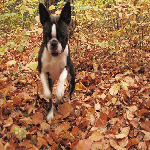

In [58]:
Image.open(PATH + fn).resize((150, 150))

In [59]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [63]:
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

19

In [ ]:
# This does not work...

#im = trn_tfms(Image.open(PATH + fn)) # AttributeError: 'JpegImageFile' object has no attribute 'shape'
im = trn_tfms(open_image(PATH + fn))
preds = to_np(learn.model(V(T(im[None].cuda())))) # AttributeError: 'numpy.ndarray' object has no attribute 'cuda'
np.argmax(preds)

In [61]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [62]:
# http://forums.fast.ai/t/how-do-we-use-our-model-against-a-specific-image/7661/101
#im = trn_tfms(Image.open(PATH + fn)) # AttributeError: 'JpegImageFile' object has no attribute 'shape'. Image.open() returns PIL.JpegImagePlugin.JpegImageFile
im = trn_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
# im = trn_tfms(np.asarray(Image.open(PATH + fn)) / 255) # This will work.
preds = learn.predict_array(im[None])
np.argmax(preds)

19